# DNN Speech Enhancement - Utsav Patel 

In the jupyter notebook, we will use pytorch to implement a simple DNN that used for speech enhancement.

In [1]:
import librosa
# import ffmpeg
import os
import torch
import torch.nn.functional as Func
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import copy

train_noisyPath = 'PREPARED_DATASET/TRAIN/'  # Used
train_cleanPath = 'PREPARED_DATASET/CLEAN/TRAIN/'
dev_noisyPath = 'PREPARED_DATASET/DEV/'  # Used
dev_cleanPath = 'PREPARED_DATASET/CLEAN/DEV/'
test_noisyPath = 'PREPARED_DATASET/TEST/'
test_cleanPath = 'PREPARED_DATASET/CLEAN/TEST/'
restfiles_Path = 'PREPARED_DATASET/REST_FILES/'

import os

train_clean_male_filenames=os.listdir(r"Speech Data/IEEE/IEEE_male/train_male")
dev_clean_male_filenames=os.listdir(r"Speech Data/IEEE/IEEE_male/development_male")
test_clean_male_filenames=os.listdir(r"Speech Data/IEEE/IEEE_male/test_male")

train_clean_female_filenames=os.listdir(r"Speech Data/IEEE/IEEE_female/train_female")
dev_clean_female_filenames=os.listdir(r"Speech Data/IEEE/IEEE_female/development_female")
test_clean_female_filenames=os.listdir(r"Speech Data/IEEE/IEEE_female/test_female")

print("CLEAN--> Male: Train Length: {} , Dev Length {} , Test length {} ".format(len(train_clean_male_filenames),len(dev_clean_male_filenames),len(test_clean_male_filenames)))
print("CLEAN--> Female: Train Length: {} , Dev Length {} , Test length {} ".format(len(train_clean_female_filenames),len(dev_clean_female_filenames),len(test_clean_female_filenames)))

train_noisy_male_filenames=os.listdir(r"PREPARED_DATASET/TRAIN_MALE/")
dev_noisy_male_filenames=os.listdir(r"PREPARED_DATASET/DEV_MALE/")
test_noisy_male_filenames=os.listdir(r"PREPARED_DATASET/TEST_MALE/")

train_noisy_female_filenames=os.listdir(r"PREPARED_DATASET/TRAIN_FEMALE/")
dev_noisy_female_filenames=os.listdir(r"PREPARED_DATASET/DEV_FEMALE/")
test_noisy_female_filenames=os.listdir(r"PREPARED_DATASET/TEST_FEMALE/")

print("NOISY --> Male: Train Length: {} , Dev Length {} , Test length {} ".format(len(train_noisy_male_filenames),len(dev_noisy_male_filenames),len(test_noisy_male_filenames)))
print("NOISY --> Female: Train Length: {} , Dev Length {} , Test length {} ".format(len(train_noisy_female_filenames),len(dev_noisy_female_filenames),len(test_noisy_female_filenames)))
########################################################################################
#########################################################################################
# Train Clean Speech
train_cleanSpeechList = train_clean_male_filenames+train_clean_female_filenames
train_cleanSpeechLength = len(train_cleanSpeechList)
print("Train Clean Total length (Male + Female) : ",train_cleanSpeechLength)

#.npy output folder
train_clean_PyPath = './Data/npy/Train_frame/Clean'

# Train Noisy Speech
train_noisySpeechList = train_noisy_male_filenames+train_noisy_female_filenames
train_noisySpeechLength = len(train_noisySpeechList)
print("Train Noisy Total length (Male + Female) : ",train_noisySpeechLength)

#.npy output folder
train_noisy_PyPath = './Data/npy/Train_frame/Noisy'


#########################################################################################
#########################################################################################
# Dev Clean Speech
dev_cleanSpeechList = dev_clean_male_filenames+dev_clean_female_filenames
dev_cleanSpeechLength = len(dev_cleanSpeechList)
print("Dev Clean Total length (Male + Female) : ",dev_cleanSpeechLength)

#.npy output folder
dev_clean_PyPath = './Data/npy/Dev_frame/Clean'

# Dev Noisy Speech
dev_noisySpeechList = dev_noisy_male_filenames+dev_noisy_female_filenames
dev_noisySpeechLength = len(dev_noisySpeechList)
print("Dev Noisy Total length (Male + Female) : ",dev_noisySpeechLength)

#.npy output folder
dev_noisy_PyPath = './Data/npy/Dev_frame/Noisy'


#########################################################################################
# Test Clean Speech
test_cleanSpeechList = test_clean_male_filenames+test_clean_female_filenames
test_cleanSpeechLength = len(test_cleanSpeechList)
print("Test Clean Total length (Male + Female) : ",test_cleanSpeechLength)


test_clean_PyPath = './Data/npy/Test_frame/Clean'

# Test Noisy Speech
test_noisySpeechList = test_noisy_male_filenames+test_noisy_female_filenames
test_noisySpeechLength = len(test_noisySpeechList)
print("Test Noisy Total length (Male + Female) : ",test_noisySpeechLength)

#.npy output folder
test_noisy_PyPath = './Data/npy/Test_frame/Noisy'

######################################################################################
#Data Path for training data
train_noisyPath = 'PREPARED_DATASET/TRAIN/'  # Used
train_cleanPath = 'PREPARED_DATASET/CLEAN/TRAIN/'
dev_noisyPath = 'PREPARED_DATASET/DEV/'  # Used
dev_cleanPath = 'PREPARED_DATASET/CLEAN/DEV/'
test_noisyPath = 'PREPARED_DATASET/TEST/'
test_cleanPath = 'PREPARED_DATASET/CLEAN/TEST/'
restfiles_Path = 'PREPARED_DATASET/REST_FILES/'

CLEAN--> Male: Train Length: 500 , Dev Length 100 , Test length 100 
CLEAN--> Female: Train Length: 500 , Dev Length 100 , Test length 100 
NOISY --> Male: Train Length: 4500 , Dev Length 900 , Test length 900 
NOISY --> Female: Train Length: 4500 , Dev Length 900 , Test length 900 
Train Clean Total length (Male + Female) :  1000
Train Noisy Total length (Male + Female) :  9000
Dev Clean Total length (Male + Female) :  200
Dev Noisy Total length (Male + Female) :  1800
Test Clean Total length (Male + Female) :  200
Test Noisy Total length (Male + Female) :  1800


# Helper Functions to calculate Target Labels. (Ideal Binary Mask, Ideal Ratio Mask, FFT-Mask)

In [2]:
def snr_calculate(speech_data,noise_data):
    speech_energy=np.sum(np.array(speech_data, dtype='int64')**2)
    noise_energy=np.sum(np.array(noise_data, dtype='int64')**2)
    ratio=speech_energy/noise_energy
    sound_level=10*math.log(ratio,10)
    return sound_level
def IBM(noisy_speech,clean_speech):
    noise=noisy_speech-clean_speech
    mask=clean_speech
    mask[clean_speech>=noise]=1
    mask[clean_speech<noise]=0
    return mask
def IRM(noisy_speech,clean_speech):
    noise=noisy_speech-clean_speech
    speech_energy=np.array(clean_speech)**2
    noise=np.array(noise)**2
    irm = np.sqrt(speech_energy / (noise + speech_energy))
    return irm
def FFT_mask(noisy_speech,clean_speech):
    # For the FFT-mask, truncate the label to values between 0 and 1 (inclusively).
    return np.clip(clean_speech/noisy_speech,0,1)

In [ ]:
# Generating absolute value of whole training data 
train_noisy_signal=np.load('Train_noisy.npy')  # this is 10*log10(np.abs(NOISYSPEECH)) value and this is feeded to input of Neural Network
train_noisy_signal=np.power(10,train_noisy_signal/10)
np.save('Abs_Train_noisy.npy',train_noisy_signal) # this is only np.abs(NOISYSPEECH) which is feeded to IBM,IRM,FFT to prepare mask

# Generating absolute value of whole training data 
dev_noisy_signal=np.load('Dev_noisy.npy')  # this is 10*log10(np.abs(NOISYSPEECH)) value and this is feeded to input of Neural Network
train_noisy_signal=np.power(10,dev_noisy_signal/10)
np.save('Abs_Dev_noisy.npy',train_noisy_signal) # this is only np.abs(NOISYSPEECH) which is feeded to IBM,IRM,FFT to prepare mask


### Create train label for all Masking used: (IBM, IRM and FFT-Mask)

In [1]:
noisy_speech=np.load("Abs_Train_noisy.npy")
clean_speech=np.load("Train_clean.npy")
X_ibm=IBM(noisy_speech,clean_speech)
np.save('train_label_ibm.npy',X_ibm)
del X_ibm
X_irm=IRM(noisy_speech,clean_speech)
np.save('train_label_irm.npy',X_irm)
del X_irm
X_fft=FFT_mask(noisy_speech,clean_speech)
np.save('train_label_fft.npy',X_fft)
del X_fft
noisy_speech=np.load("Abs_Dev_noisy.npy")
clean_speech=np.load("Dev_clean.npy")
X_ibm=IBM(noisy_speech,clean_speech)
np.save('dev_label_ibm.npy',X_ibm)
del X_ibm
X_irm=IRM(noisy_speech,clean_speech)
np.save('dev_label_irm.npy',X_irm)
del X_irm
X_fft=FFT_mask(noisy_speech,clean_speech)
np.save('dev_label_fft.npy',X_fft)
del X_fft

## Train separate DNNs that individually estimate the clean speech spectrogram, FFT mask, IBM, and IRM. In other words, we should have four different DNNs, one for each training target. Use the parameters and network structure that is outlined in the paper. We have tested the network with the validation/development data after each Epoch and perform model selection with the best performing result. For each DNN, generate and plot error curves (MSE) as a function of Epoch for the training and validation/development set. After the networks are trained, test each of the networks with the testing data set. Generate plots that show the average MSE between the estimated and true clean speech time-domain signals for each training target.

## Model

### Model Structure
Next, we will start to construct our model. In this tutorial, we only use a simple 4-layer DNN. 

The input data has a dimension of n * 257 which n is the time stamps and 257 is the number of frequency bins.
The dimension of hidden layers and output layer is describe as following. Each layer will be followed by a RELU activation layer.

### NORMALIZATION

In [3]:
#Dataloader for traning data

# SPECTOGRAM OUTPUT 

class trainDataLoader(data.Dataset):
    def __init__(self,label_file,data_file):
        print(label_file,data_file)
        self.labelPath = np.load(label_file)
        self.dataPath = np.load(data_file)
    def __getitem__(self, index):
        xFile = self.dataPath.T[index]
        mFile = self.labelPath.T[index]
        return torch.from_numpy(xFile), torch.from_numpy(mFile)
    def __len__(self):
        #Number of files
        return self.dataPath.shape[1]
    
class valDataLoader(data.Dataset):
    def __init__(self,label_file,data_file):
        print(label_file,data_file)
        self.labelPath = np.load(label_file)
        self.dataPath = np.load(data_file)
    def __getitem__(self, index):
        xFile = self.dataPath.T[index]
        mFile = self.labelPath.T[index]
        return torch.from_numpy(xFile), torch.from_numpy(mFile)
    def __len__(self):
        return self.dataPath.shape[1]
    
class testDataLoader(data.Dataset):
    def __init__(self,label_file,data_file):
        self.labelPath = np.load(label_file)
        self.dataPath = np.load(data_file)
    def __getitem__(self, index):
        xFile = self.dataPath.T[index]
        mFile = self.labelPath.T[index]
        return torch.from_numpy(xFile), torch.from_numpy(mFile)
    def __len__(self):
        return self.dataPath.shape[1]

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(257,1024)
        self.fc2 = nn.Linear(1024,1024)
        self.fc3 = nn.Linear(1024,1024)
        self.fc4 = nn.Linear(1024,257)        
    def forward(self,audio):
        audio = Func.relu(self.fc1(audio))
        audio = Func.relu(self.fc2(audio))
        audio = Func.relu(self.fc3(audio))
        audio = self.fc4(audio)
        return audio
def weights(m):
    if isinstance(m,nn.Linear):
        nn.init.xavier_normal(m.weight.data)
        nn.init.constant(m.bias.data,0.1)

### Traning Process


In [5]:
def train_model(model,trainData,valData,num_epochs):
    best_model = copy.deepcopy(model.state_dict())
    best_loss = 9999
    train_loss=[]
    validation_loss=[]
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        loss = 0.0 
        vali_loss = 0.0
        for step, (audio, target) in enumerate(trainData):
            if(step%15==0):
                print("Train step:"+str(step)+"/"+str(len(trainData)))
            audio=audio.float()
            target=target.float()
            model.train()
            model=model.float()
            output = model(audio)
            newLoss = criterion(output,target)
            loss += newLoss.data
            optimizer.zero_grad()
            newLoss.backward()
            optimizer.step()
        for step, (audio, target) in enumerate(valData):
            audio=audio.float()
            target=target.float()
            model.eval()
            output = model(audio)
            new_valiLoss = criterion(output,target)
            vali_loss += new_valiLoss.data
            if vali_loss < best_loss:
                best_loss = vali_loss
                best_model = copy.deepcopy(model.state_dict())
            #if(step%30==0):
             #   print("Valid step:"+str(step)+"/"+str(len(valData)))
        print('Epoch:{:2}, Train Loss: {:>.5f}'.format(epoch,loss/len(trainData)))
        print('Epoch:{:2}, Valid Loss: {:>.5f}'.format(epoch,vali_loss/len(valData))) 
        train_loss.append(loss/len(trainData))
        validation_loss.append(vali_loss/len(valData))
    return train_loss,validation_loss,best_model

## NORMALIZED data input and  SPECTOGRAM as output label.

In [31]:
model = Net()
model.apply(weights)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.cuda()
#model = #
#criterion.cuda()

label_file='Train_clean.npy'
data_file='Normalization_Train_noisy.npy'
trainData = data.DataLoader(trainDataLoader(label_file,data_file),batch_size = 40000,drop_last = False) 
label_file='Dev_clean.npy'
data_file='Normalization_Dev_noisy.npy'
valData = data.DataLoader(valDataLoader(label_file,data_file),batch_size = 40000,drop_last = False) 
train_loss,validation_loss,best_model=train_model(model,trainData,valData,20)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


Train_clean.npy Normalization_Train_noisy.npy
Dev_clean.npy Normalization_Dev_noisy.npy
Epoch 0/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 0, Train Loss: 0.20073
Epoch: 0, Valid Loss: 0.19557
Epoch 1/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 1, Train Loss: 0.18959
Epoch: 1, Valid Loss: 0.19205
Epoch 2/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 2, Train Loss: 0.18703
Epoch: 2, Valid Loss: 0.18498
Epoch 3/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 3, Train Loss: 0.18085
Epoch: 3, Valid Loss: 0.17817
Epoch 4/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 4, Train Loss: 0.17573
Epoch: 4, Valid Loss: 0.18153
Epoch 5/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 5, Train Loss: 0.17372
Epoch: 5, Valid Loss: 0.

Text(0, 0.5, 'Loss')

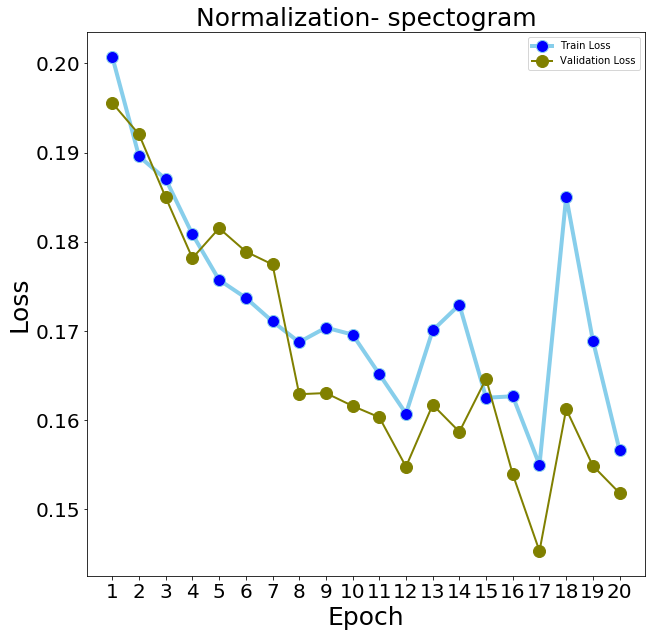

In [83]:
train_loss=np.load("train_loss.npy")
validation_loss=np.load("validation_loss.npy")
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))   
plt.plot(range(1,21),train_loss, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label='Train Loss')
plt.plot(range(1,21),validation_loss, marker='o', color='olive',markersize=12, linewidth=2,label='Validation Loss')
plt.xticks(range(1,21),fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
plt.title("Normalization- spectogram",fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("Loss",fontsize=25)

### Save your model
You can save your best model

In [33]:
torch.save(best_model, './norm_spectogram.pth')
np.save('train_loss.npy',train_loss)
np.save('validation_loss.npy',validation_loss)

In [6]:
norm_spectogram = Net()
norm_spectogram.load_state_dict(torch.load('./norm_spectogram.pth'))

<All keys matched successfully>

In [9]:
def generate_test_data(model,testpath,testfiles,outputpath,maximum,minimum,mean,std,input_type):
    mse=[]
    for step in range(0,len(testfiles)):
        sx,sr = librosa.load(test_noisyPath +testfiles[step] ,sr=16000)
        S = librosa.stft(sx,n_fft=512,hop_length=160,win_length=320)
        abs_S = 10*np.log10(np.abs(S))
        phase=S/np.abs(S)
        if(input_type=="standardization"):
            abs_S=(abs_S-mean)/std
        elif(input_type=="normalization"):
            abs_S=(abs_S-minimum)/(maximum-minimum)
        else:
            print("ERROR")
        audio=torch.from_numpy(abs_S.astype('float32')).t()
        model.eval()
        mask=model(audio)
        mask=np.transpose(mask.cpu().data.numpy().squeeze())
        output=phase*(mask*abs_S)
        output=librosa.istft(output,hop_length=160,win_length=320)
        if(output.shape[0]<sx.shape[0]):
            output=np.pad(output, (0,sx.shape[0]-output.shape[0]),'constant')
        elif(output.shape[0]>sx.shape[0]):
            sx=np.pad(sx, (0,output.shape[0]-sx.shape[0]),'constant')
        mse.append(np.mean((output-sx)**2))
        output_filename=testfiles[step]
        librosa.output.write_wav(outputpath+output_filename,output,16000)
    return mse,len(testfiles)

import math
combined_file_arr=np.load('Test_noisy.npy')
combined_file_arr[combined_file_arr==-math.inf]=-100
combined_file_arr.shape
mean_X=np.mean(combined_file_arr,axis=1)
std_X=np.std(combined_file_arr,axis=1)
min_X=np.min(combined_file_arr,axis=1)
max_X=np.max(combined_file_arr,axis=1)

mse_1,length_testfiles=generate_test_data(norm_spectogram,test_noisyPath,test_noisySpeechList,'./TEST_PREDICTION/',max_X.reshape(257,1),min_X.reshape(257,1),mean_X.reshape(257,1),std_X.reshape(257,1),"normalization")

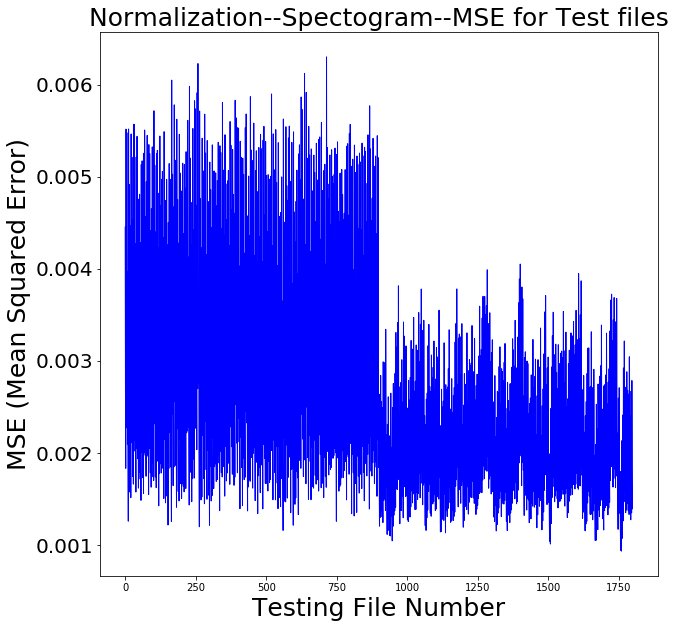

In [15]:
mse_1,length_testfiles=generate_test_data(norm_spectogram,test_noisyPath,test_noisySpeechList,'./TEST_PREDICTION/',max_X.reshape(257,1),min_X.reshape(257,1),mean_X.reshape(257,1),std_X.reshape(257,1),"normalization")
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))   
plt.plot(range(length_testfiles),mse_1,color='blue', linewidth=1)
#plt.xticks(range(length_testfiles),fontsize=20)
plt.yticks(fontsize=20)
plt.title('Normalization--Spectogram--MSE for Test files',fontsize=25)
plt.xlabel("Testing File Number",fontsize=25)
plt.ylabel("MSE (Mean Squared Error)",fontsize=25)
plt.show()

## NORMALIZED data input and  IBM as output label.

In [7]:
model = Net()
model.apply(weights)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.cuda()
#model = #
#criterion.cuda()

label_file='train_label_ibm.npy'
data_file='Normalization_Train_noisy.npy'
trainData = data.DataLoader(trainDataLoader(label_file,data_file),batch_size = 40000,drop_last = False) 
label_file='dev_label_ibm.npy'
data_file='Normalization_Dev_noisy.npy'
valData = data.DataLoader(valDataLoader(label_file,data_file),batch_size = 40000,drop_last = False) 
train_loss_2,validation_loss_2,best_model_2=train_model(model,trainData,valData,20)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


train_label_ibm.npy Normalization_Train_noisy.npy
dev_label_ibm.npy Normalization_Dev_noisy.npy
Epoch 0/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 0, Train Loss: 0.18981
Epoch: 0, Valid Loss: 0.17586
Epoch 1/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 1, Train Loss: 0.18006
Epoch: 1, Valid Loss: 0.17551
Epoch 2/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 2, Train Loss: 0.17892
Epoch: 2, Valid Loss: 0.17331
Epoch 3/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 3, Train Loss: 0.17733
Epoch: 3, Valid Loss: 0.18542
Epoch 4/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 4, Train Loss: 0.17605
Epoch: 4, Valid Loss: 0.17319
Epoch 5/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 5, Train Loss: 0.17473
Epoch: 5, Valid 

In [8]:
torch.save(best_model_2, './norm_ibm.pth')
np.save('train_loss_2.npy',train_loss_2)
np.save('validation_loss_2.npy',validation_loss_2)

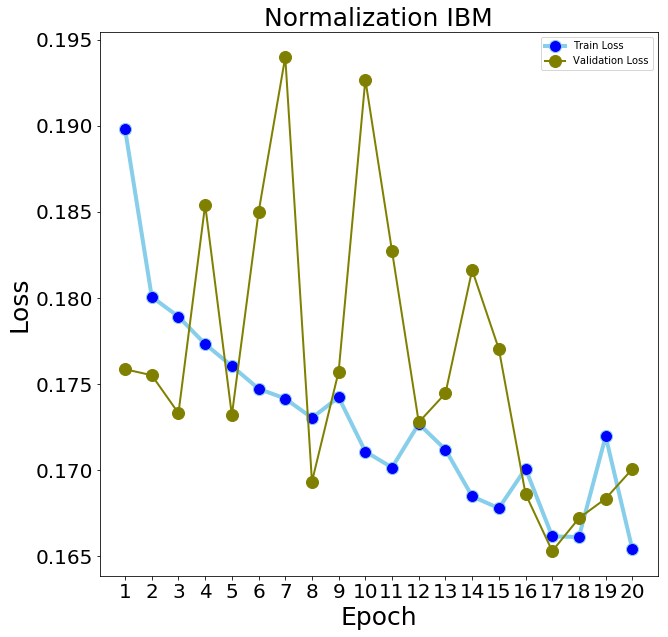

In [82]:
train_loss_2=np.load('train_loss_2.npy')
validation_loss_2=np.load('validation_loss_2.npy')

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))   
plt.plot(range(1,21),train_loss_2, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label='Train Loss')
plt.plot(range(1,21),validation_loss_2, marker='o', color='olive',markersize=12, linewidth=2,label='Validation Loss')
plt.xticks(range(1,21),fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
plt.title("Normalization IBM",fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("Loss",fontsize=25)
plt.show()

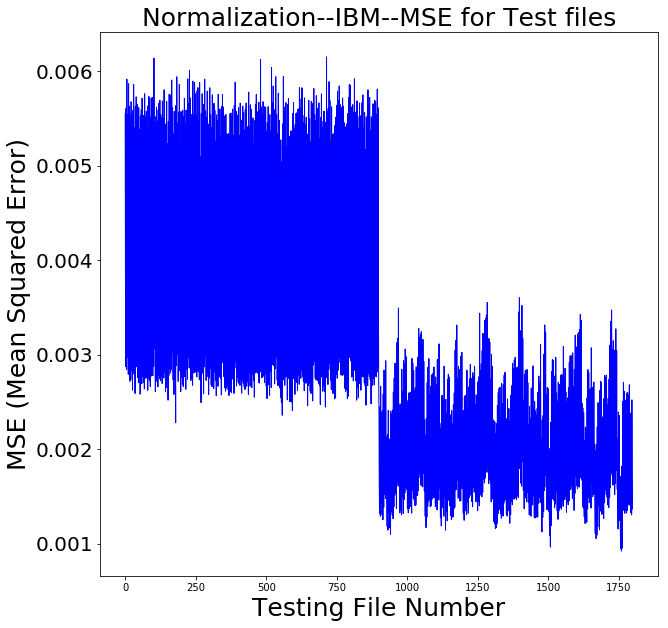

In [17]:
norm_ibm = Net()
norm_ibm.load_state_dict(torch.load('./norm_ibm.pth'))

mse_2,length_testfiles=generate_test_data(norm_ibm,test_noisyPath,test_noisySpeechList,'./TEST_PREDICTION/',max_X.reshape(257,1),min_X.reshape(257,1),mean_X.reshape(257,1),std_X.reshape(257,1),"normalization")
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))   
plt.plot(range(length_testfiles),mse_2,color='blue', linewidth=1)
#plt.xticks(range(length_testfiles),fontsize=20)
plt.yticks(fontsize=20)
plt.title('Normalization--IBM--MSE for Test files',fontsize=25)
plt.xlabel("Testing File Number",fontsize=25)
plt.ylabel("MSE (Mean Squared Error)",fontsize=25)
plt.show()

## NORMALIZED data input and  IRM as output label.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


train_label_irm.npy Normalization_Train_noisy.npy
dev_label_irm.npy Normalization_Dev_noisy.npy
Epoch 0/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 0, Train Loss: 0.11448
Epoch: 0, Valid Loss: 0.10421
Epoch 1/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 1, Train Loss: 0.10629
Epoch: 1, Valid Loss: 0.10415
Epoch 2/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 2, Train Loss: 0.10581
Epoch: 2, Valid Loss: 0.10316
Epoch 3/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 3, Train Loss: 0.10515
Epoch: 3, Valid Loss: 0.10315
Epoch 4/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 4, Train Loss: 0.10424
Epoch: 4, Valid Loss: 0.10356
Epoch 5/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 5, Train Loss: 0.10436
Epoch: 5, Valid 

Text(0, 0.5, 'Loss')

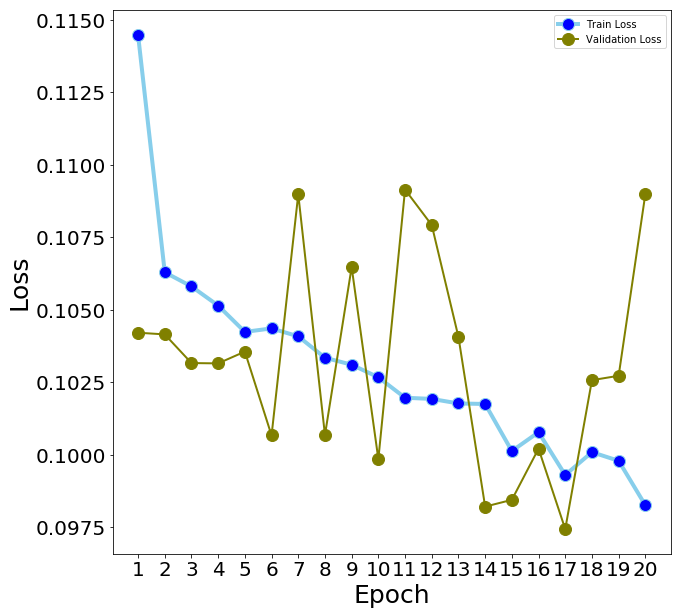

In [11]:
# NORMALIZATION--> IRM  

model = Net()
model.apply(weights)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.cuda()
#model = #
#criterion.cuda()

label_file='train_label_irm.npy'
data_file='Normalization_Train_noisy.npy'
trainData = data.DataLoader(trainDataLoader(label_file,data_file),batch_size = 40000,drop_last = False) 
label_file='dev_label_irm.npy'
data_file='Normalization_Dev_noisy.npy'
valData = data.DataLoader(valDataLoader(label_file,data_file),batch_size = 40000,drop_last = False) 
train_loss_3,validation_loss_3,best_model_3=train_model(model,trainData,valData,20)

torch.save(best_model_3, './norm_irm.pth')
np.save('train_loss_3.npy',train_loss_3)
np.save('validation_loss_3.npy',validation_loss_3)


Text(0, 0.5, 'Loss')

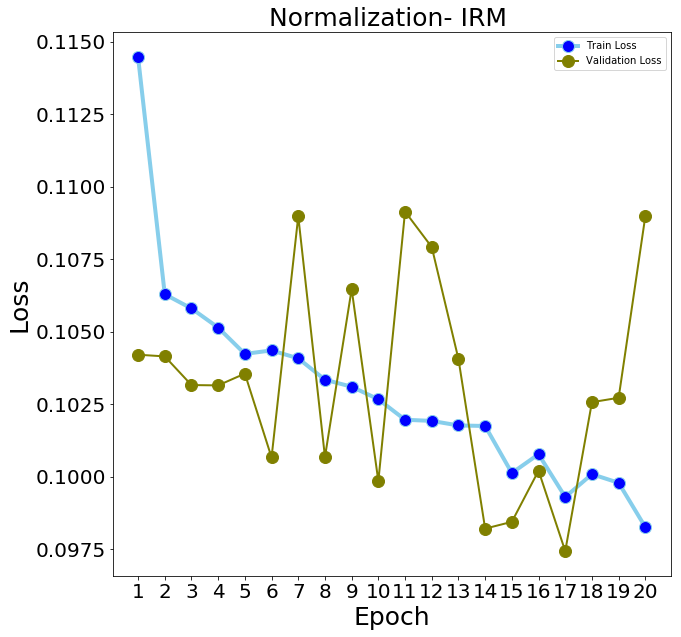

In [84]:
train_loss_3=np.load('train_loss_3.npy')
validation_loss_3=np.load('validation_loss_3.npy')

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))   
plt.plot(range(1,21),train_loss_3, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label='Train Loss')
plt.plot(range(1,21),validation_loss_3, marker='o', color='olive',markersize=12, linewidth=2,label='Validation Loss')
plt.xticks(range(1,21),fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
plt.title("Normalization- IRM ",fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("Loss",fontsize=25)

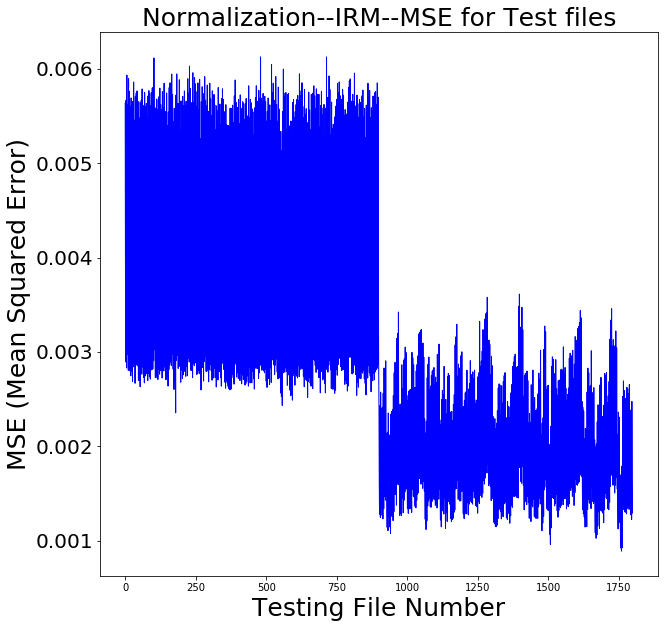

In [18]:
norm_irm = Net()
norm_irm.load_state_dict(torch.load('./norm_irm.pth'))

mse_3,length_testfiles=generate_test_data(norm_irm,test_noisyPath,test_noisySpeechList,'./TEST_PREDICTION/',max_X.reshape(257,1),min_X.reshape(257,1),mean_X.reshape(257,1),std_X.reshape(257,1),"normalization")
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))   
plt.plot(range(length_testfiles),mse_3,color='blue', linewidth=1)
#plt.xticks(range(length_testfiles),fontsize=20)
plt.yticks(fontsize=20)
plt.title('Normalization--IRM--MSE for Test files',fontsize=25)
plt.xlabel("Testing File Number",fontsize=25)
plt.ylabel("MSE (Mean Squared Error)",fontsize=25)
plt.show()

## NORMALIZED data input and  FFT-MASK as output label.

In [19]:
# NORMALIZATION--> FFT_MASK  

model = Net()
model.apply(weights)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.cuda()
#model = #
#criterion.cuda()

label_file='train_label_fft.npy'
data_file='Normalization_Train_noisy.npy'
trainData = data.DataLoader(trainDataLoader(label_file,data_file),batch_size = 40000,drop_last = False) 
label_file='dev_label_fft.npy'
data_file='Normalization_Dev_noisy.npy'
valData = data.DataLoader(valDataLoader(label_file,data_file),batch_size = 40000,drop_last = False) 
train_loss_4,validation_loss_4,best_model_4=train_model(model,trainData,valData,20)

torch.save(best_model_4, './norm_fft.pth')
np.save('train_loss_4.npy',train_loss_4)
np.save('validation_loss_4.npy',validation_loss_4)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


train_label_fft.npy Normalization_Train_noisy.npy
dev_label_fft.npy Normalization_Dev_noisy.npy
Epoch 0/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 0, Train Loss: 0.12227
Epoch: 0, Valid Loss: 0.11636
Epoch 1/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 1, Train Loss: 0.11188
Epoch: 1, Valid Loss: 0.11644
Epoch 2/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 2, Train Loss: 0.11088
Epoch: 2, Valid Loss: 0.11825
Epoch 3/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 3, Train Loss: 0.11000
Epoch: 3, Valid Loss: 0.12003
Epoch 4/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 4, Train Loss: 0.10867
Epoch: 4, Valid Loss: 0.12859
Epoch 5/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 5, Train Loss: 0.10784
Epoch: 5, Valid 

Text(0, 0.5, 'Loss')

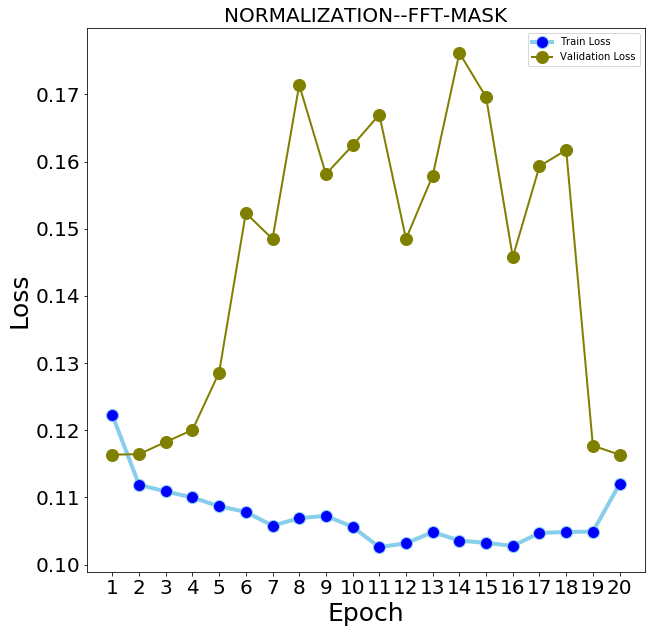

In [21]:
train_loss_4=np.load('train_loss_4.npy')
validation_loss_4=np.load('validation_loss_4.npy')

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))   
plt.plot(range(1,21),train_loss_4, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label='Train Loss')
plt.plot(range(1,21),validation_loss_4, marker='o', color='olive',markersize=12, linewidth=2,label='Validation Loss')
plt.xticks(range(1,21),fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
plt.title("NORMALIZATION--FFT-MASK",fontsize=20)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("Loss",fontsize=25)

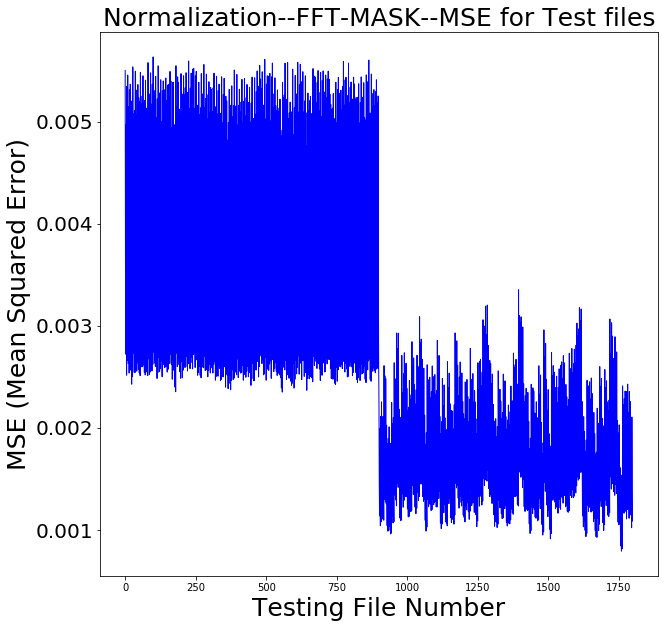

In [22]:
norm_fft = Net()
norm_fft.load_state_dict(torch.load('./norm_fft.pth'))

mse_4,length_testfiles=generate_test_data(norm_fft,test_noisyPath,test_noisySpeechList,'./TEST_PREDICTION/',max_X.reshape(257,1),min_X.reshape(257,1),mean_X.reshape(257,1),std_X.reshape(257,1),"normalization")
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))   
plt.plot(range(length_testfiles),mse_4,color='blue', linewidth=1)
#plt.xticks(range(length_testfiles),fontsize=20)
plt.yticks(fontsize=20)
plt.title('Normalization--FFT-MASK--MSE for Test files',fontsize=25)
plt.xlabel("Testing File Number",fontsize=25)
plt.ylabel("MSE (Mean Squared Error)",fontsize=25)
plt.show()

## STANDARDIZED data input and  SPECTOGRAM as output label.

In [9]:
# Standardization SPECTOGRAM

model = Net()
model.apply(weights)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.cuda()
#model = #
#criterion.cuda()

label_file='Train_clean.npy'
data_file='Standardization_Train_noisy.npy'
trainData = data.DataLoader(trainDataLoader(label_file,data_file),batch_size = 40000,drop_last = False) 
label_file='Dev_clean.npy'
data_file='Standardization_Dev_noisy.npy'
valData = data.DataLoader(valDataLoader(label_file,data_file),batch_size = 40000,drop_last = False) 
train_loss,validation_loss,best_model=train_model(model,trainData,valData,20)
train_loss_5,validation_loss_5,best_model_5=train_loss,validation_loss,best_model

torch.save(best_model_5, './standard_spectogram.pth')
np.save('train_loss_5.npy',train_loss_5)
np.save('validation_loss_5.npy',validation_loss_5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


Train_clean.npy Standardization_Train_noisy.npy
Dev_clean.npy Standardization_Dev_noisy.npy
Epoch 0/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 0, Train Loss: 0.13346
Epoch: 0, Valid Loss: 0.10614
Epoch 1/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 1, Train Loss: 0.08605
Epoch: 1, Valid Loss: 0.08853
Epoch 2/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 2, Train Loss: 0.06942
Epoch: 2, Valid Loss: 0.07425
Epoch 3/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 3, Train Loss: 0.06055
Epoch: 3, Valid Loss: 0.06820
Epoch 4/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 4, Train Loss: 0.05611
Epoch: 4, Valid Loss: 0.06480
Epoch 5/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 5, Train Loss: 0.05299
Epoch: 5, Valid Loss

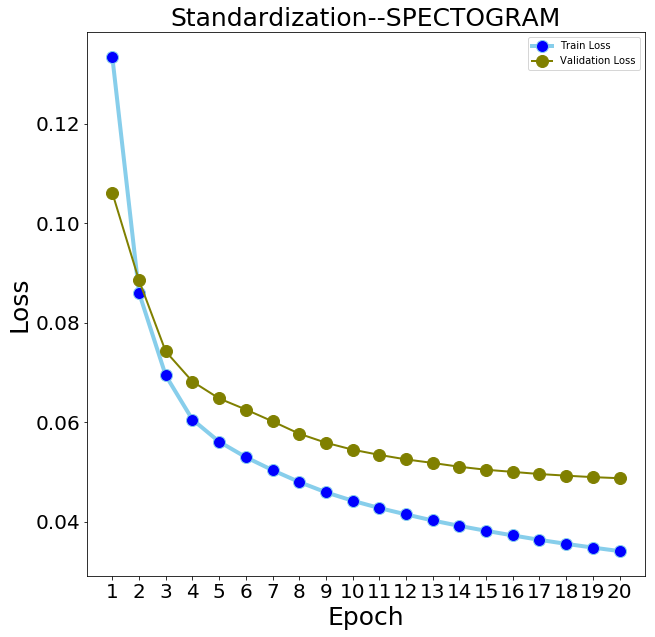

In [14]:
train_loss_5=np.load('train_loss_5.npy')
validation_loss_5=np.load('validation_loss_5.npy')
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))   
plt.plot(range(1,21),train_loss_5, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label='Train Loss')
plt.plot(range(1,21),validation_loss_5, marker='o', color='olive',markersize=12, linewidth=2,label='Validation Loss')
plt.xticks(range(1,21),fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
plt.title("Standardization--SPECTOGRAM",fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("Loss",fontsize=25)
plt.show()

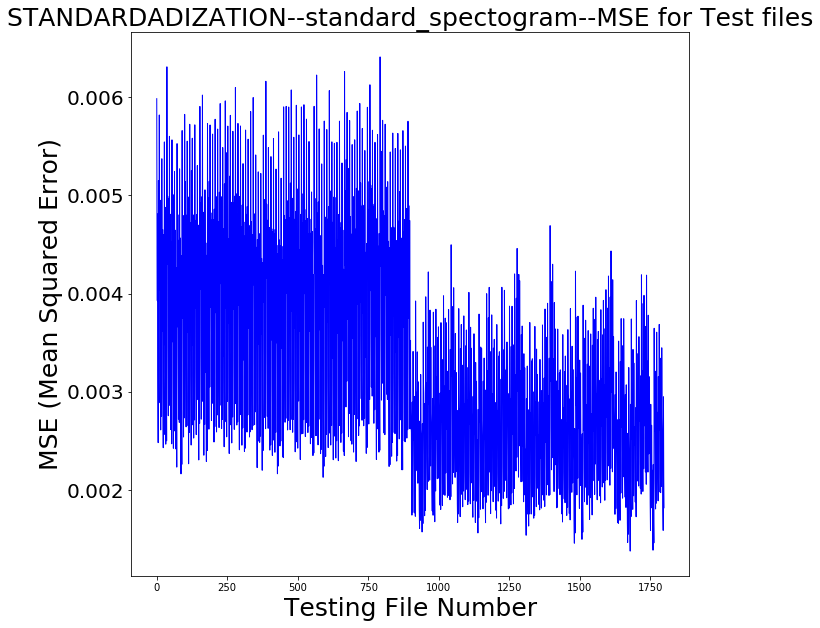

In [23]:
standard_spectogram = Net()
standard_spectogram.load_state_dict(torch.load('./standard_spectogram.pth'))

mse_5,length_testfiles=generate_test_data(standard_spectogram,test_noisyPath,test_noisySpeechList,'./TEST_PREDICTION/',max_X.reshape(257,1),min_X.reshape(257,1),mean_X.reshape(257,1),std_X.reshape(257,1),"standardization")
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))   
plt.plot(range(length_testfiles),mse_5,color='blue', linewidth=1)
#plt.xticks(range(length_testfiles),fontsize=20)
plt.yticks(fontsize=20)
plt.title('STANDARDADIZATION--standard_spectogram--MSE for Test files',fontsize=25)
plt.xlabel("Testing File Number",fontsize=25)
plt.ylabel("MSE (Mean Squared Error)",fontsize=25)
plt.show()

## STANDARDIZED data input and  FFT-MASK as output label.

In [6]:
# Standardization--> FFT_MASK  

model = Net()
model.apply(weights)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.cuda()
#model = #
#criterion.cuda()

label_file='train_label_fft.npy'
data_file='Standardization_Train_noisy.npy'
trainData = data.DataLoader(trainDataLoader(label_file,data_file),batch_size = 40000,drop_last = False) 
label_file='dev_label_fft.npy'
data_file='Standardization_Dev_noisy.npy'
valData = data.DataLoader(valDataLoader(label_file,data_file),batch_size = 40000,drop_last = False) 
train_loss_6,validation_loss_6,best_model_6=train_model(model,trainData,valData,20)

torch.save(best_model_6, './standard_fft.pth')
np.save('train_loss_6.npy',train_loss_6)
np.save('validation_loss_6.npy',validation_loss_6)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


train_label_fft.npy Standardization_Train_noisy.npy
dev_label_fft.npy Standardization_Dev_noisy.npy
Epoch 0/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 0, Train Loss: 0.10288
Epoch: 0, Valid Loss: 0.14329
Epoch 1/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 1, Train Loss: 0.07876
Epoch: 1, Valid Loss: 0.14763
Epoch 2/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 2, Train Loss: 0.07484
Epoch: 2, Valid Loss: 0.15060
Epoch 3/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 3, Train Loss: 0.07274
Epoch: 3, Valid Loss: 0.15249
Epoch 4/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 4, Train Loss: 0.07111
Epoch: 4, Valid Loss: 0.15348
Epoch 5/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 5, Train Loss: 0.06978
Epoch: 5, Va

In [9]:
train_loss_6=np.load('train_loss_6.npy')
validation_loss_6=np.load('validation_loss_6.npy')

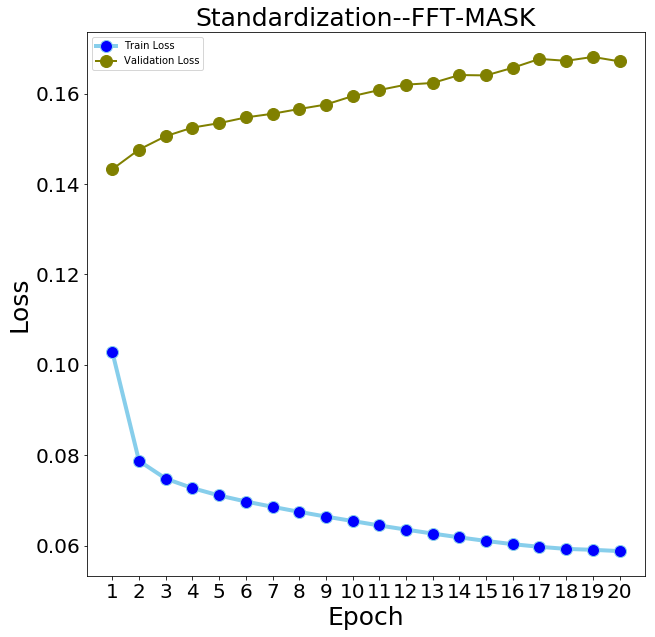

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))   
plt.plot(range(1,21),train_loss_6, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label='Train Loss')
plt.plot(range(1,21),validation_loss_6, marker='o', color='olive',markersize=12, linewidth=2,label='Validation Loss')
plt.xticks(range(1,21),fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
plt.title("Standardization--FFT-MASK",fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("Loss",fontsize=25)
plt.show()

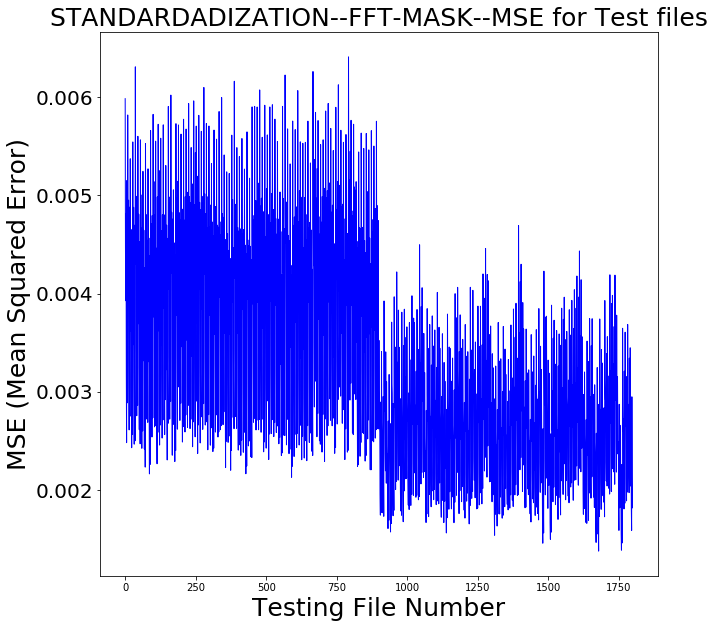

In [36]:
standard_fft = Net()
standard_fft.load_state_dict(torch.load('./standard_fft.pth'))

mse_6,length_testfiles=generate_test_data(standard_fft,test_noisyPath,test_noisySpeechList,'./TEST_PREDICTION/',max_X.reshape(257,1),min_X.reshape(257,1),mean_X.reshape(257,1),std_X.reshape(257,1),"standardization")
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))   
plt.plot(range(length_testfiles),mse_6,color='blue', linewidth=1)
#plt.xticks(range(length_testfiles),fontsize=20)
plt.yticks(fontsize=20)
plt.title('STANDARDADIZATION--FFT-MASK--MSE for Test files',fontsize=25)
plt.xlabel("Testing File Number",fontsize=25)
plt.ylabel("MSE (Mean Squared Error)",fontsize=25)
plt.show()

## STANDARDIZED data input and  IRM as output label.

In [6]:
# Standardization--> IRM  

model = Net()
model.apply(weights)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.cuda()
#model = #
#criterion.cuda()

label_file='train_label_irm.npy'
data_file='Standardization_Train_noisy.npy'
trainData = data.DataLoader(trainDataLoader(label_file,data_file),batch_size = 40000,drop_last = False) 
label_file='dev_label_irm.npy'
data_file='Standardization_Dev_noisy.npy'
valData = data.DataLoader(valDataLoader(label_file,data_file),batch_size = 40000,drop_last = False) 
train_loss_7,validation_loss_7,best_model_7=train_model(model,trainData,valData,20)

torch.save(best_model_7, './standard_irm.pth')
np.save('train_loss_7.npy',train_loss_7)
np.save('validation_loss_7.npy',validation_loss_7)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


train_label_irm.npy Standardization_Train_noisy.npy
dev_label_irm.npy Standardization_Dev_noisy.npy
Epoch 0/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 0, Train Loss: 0.10346
Epoch: 0, Valid Loss: 0.08689
Epoch 1/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 1, Train Loss: 0.08306
Epoch: 1, Valid Loss: 0.08267
Epoch 2/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 2, Train Loss: 0.07987
Epoch: 2, Valid Loss: 0.08040
Epoch 3/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 3, Train Loss: 0.07797
Epoch: 3, Valid Loss: 0.07893
Epoch 4/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 4, Train Loss: 0.07654
Epoch: 4, Valid Loss: 0.07779
Epoch 5/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 5, Train Loss: 0.07535
Epoch: 5, Va

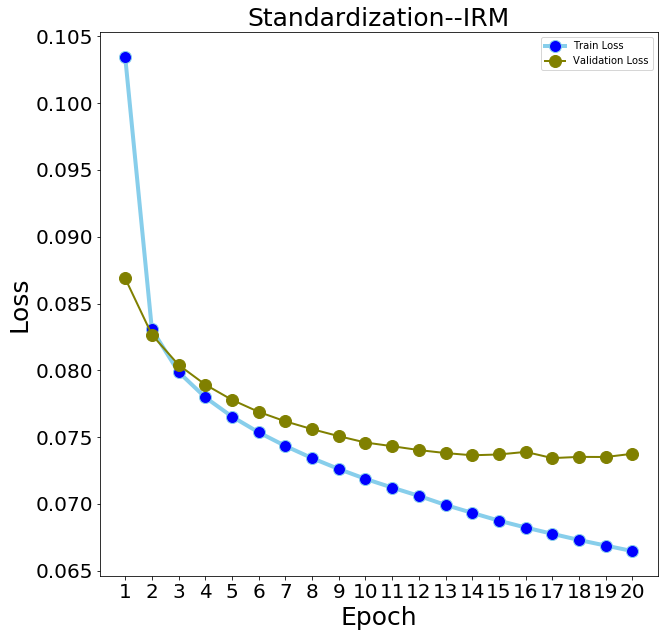

In [13]:
train_loss_7=np.load('train_loss_7.npy')
validation_loss_7=np.load('validation_loss_7.npy')

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))   
plt.plot(range(1,21),train_loss_7, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label='Train Loss')
plt.plot(range(1,21),validation_loss_7, marker='o', color='olive',markersize=12, linewidth=2,label='Validation Loss')
plt.xticks(range(1,21),fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
plt.title("Standardization--IRM",fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("Loss",fontsize=25)
plt.show()

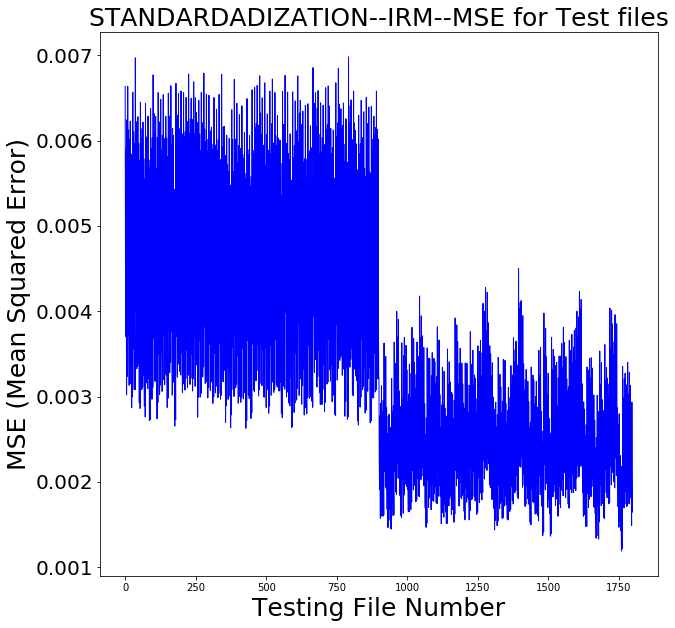

In [35]:
standard_irm = Net()
standard_irm.load_state_dict(torch.load('./standard_irm.pth'))

mse_7,length_testfiles=generate_test_data(standard_irm,test_noisyPath,test_noisySpeechList,'./TEST_PREDICTION/',max_X.reshape(257,1),min_X.reshape(257,1),mean_X.reshape(257,1),std_X.reshape(257,1),"standardization")
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))   
plt.plot(range(length_testfiles),mse_7,color='blue', linewidth=1)
#plt.xticks(range(length_testfiles),fontsize=20)
plt.yticks(fontsize=20)
plt.title('STANDARDADIZATION--IRM--MSE for Test files',fontsize=25)
plt.xlabel("Testing File Number",fontsize=25)
plt.ylabel("MSE (Mean Squared Error)",fontsize=25)
plt.show()

## STANDARDIZED data input and  IBM as output label.

In [6]:
# Standardization--> IBM  

model = Net()
model.apply(weights)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.cuda()
#model = #
#criterion.cuda()

label_file='train_label_ibm.npy'
data_file='Standardization_Train_noisy.npy'
trainData = data.DataLoader(trainDataLoader(label_file,data_file),batch_size = 40000,drop_last = False) 
label_file='dev_label_ibm.npy'
data_file='Standardization_Dev_noisy.npy'
valData = data.DataLoader(valDataLoader(label_file,data_file),batch_size = 40000,drop_last = False) 
train_loss_8,validation_loss_8,best_model_8=train_model(model,trainData,valData,20)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


train_label_ibm.npy Standardization_Train_noisy.npy
dev_label_ibm.npy Standardization_Dev_noisy.npy
Epoch 0/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 0, Train Loss: 0.16677
Epoch: 0, Valid Loss: 0.14505
Epoch 1/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 1, Train Loss: 0.13913
Epoch: 1, Valid Loss: 0.13851
Epoch 2/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 2, Train Loss: 0.13427
Epoch: 2, Valid Loss: 0.13470
Epoch 3/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 3, Train Loss: 0.13139
Epoch: 3, Valid Loss: 0.13207
Epoch 4/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 4, Train Loss: 0.12923
Epoch: 4, Valid Loss: 0.13059
Epoch 5/19
Train step:0/50
Train step:15/50
Train step:30/50
Train step:45/50
Valid step:0/5
Epoch: 5, Train Loss: 0.12747
Epoch: 5, Va

In [ ]:
torch.save(best_model_8, './standard_ibm.pth')
np.save('train_loss_8.npy',train_loss_8)
np.save('validation_loss_8.npy',validation_loss_8)

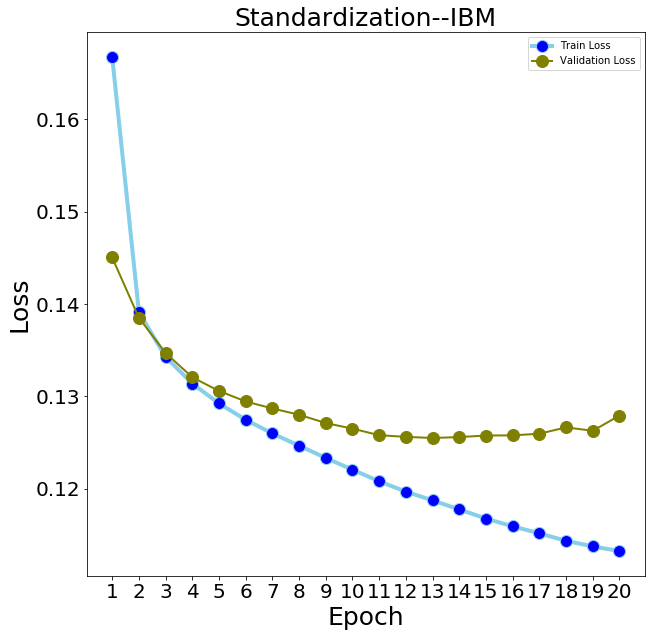

In [11]:
train_loss_8=np.load('train_loss_8.npy')
validation_loss_8=np.load('validation_loss_8.npy')

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))   
plt.plot(range(1,21),train_loss_8, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label='Train Loss')
plt.plot(range(1,21),validation_loss_8, marker='o', color='olive',markersize=12, linewidth=2,label='Validation Loss')
plt.xticks(range(1,21),fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
plt.title("Standardization--IBM",fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("Loss",fontsize=25)
plt.show()

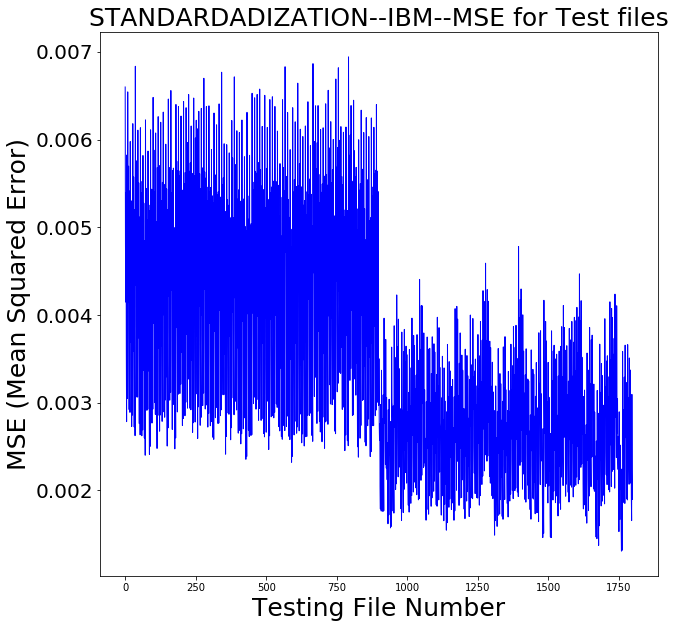

In [31]:
standard_ibm = Net()
standard_ibm.load_state_dict(torch.load('./standard_ibm.pth'))

mse_8,length_testfiles=generate_test_data(standard_ibm,test_noisyPath,test_noisySpeechList,'./TEST_PREDICTION/',max_X.reshape(257,1),min_X.reshape(257,1),mean_X.reshape(257,1),std_X.reshape(257,1),"standardization")
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))   
plt.plot(range(length_testfiles),mse_8,color='blue', linewidth=1)
#plt.xticks(range(length_testfiles),fontsize=20)
plt.yticks(fontsize=20)
plt.title('STANDARDADIZATION--IBM--MSE for Test files',fontsize=25)
plt.xlabel("Testing File Number",fontsize=25)
plt.ylabel("MSE (Mean Squared Error)",fontsize=25)
plt.show()

### Standardization vs Normalization

### Some More exploraion: Taking one of the noisy speech signals (and corresponding speech and noise components) and generating the IBM and IRM masks. Plotting the spectrograms for the noisy speech signal, clean speech component, noise component . Also, generating plots for the corresponding IBM and IRM.

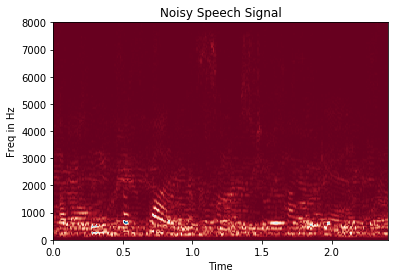

In [40]:
noisy_signal_filepath='PREPARED_DATASET/TEST/l61s01__0_0.wav'
sx,sr = librosa.load(noisy_signal_filepath,sr=None)
noisy_signal = np.abs(librosa.stft(sx,n_fft=512,hop_length=160,win_length=320))
extent=[0,len(sx)/sr,0,8000]
plt.title("Noisy Speech Signal")
plt.ylabel("Freq in Hz")
plt.xlabel("Time")
plt.imshow(noisy_signal,origin='lowest',aspect='auto',extent=extent,cmap='RdBu')

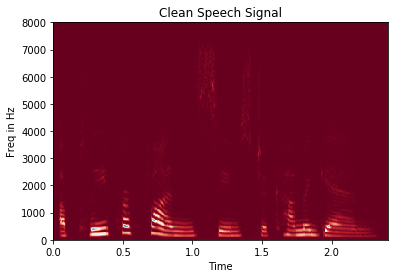

In [74]:
clean_filepath='PREPARED_DATASET/CLEAN/TEST/l61s01.wav'
sx,sr = librosa.load(clean_filepath,sr=None)
clean = np.abs(librosa.stft(sx,n_fft=512,hop_length=160,win_length=320))
extent=[0,len(sx)/sr,0,8000]
plt.title("Clean Speech Signal")
plt.ylabel("Freq in Hz")
plt.xlabel("Time")
plt.imshow(clean,origin='lowest',aspect='auto',extent=extent,cmap='RdBu')

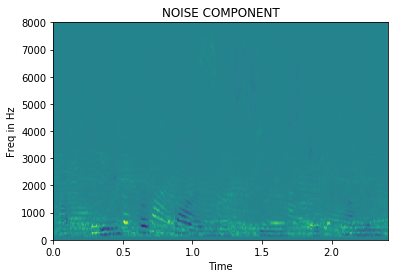

In [75]:
noise=noisy_signal-clean
extent=[0,len(sx)/sr,0,8000]
plt.title("NOISE COMPONENT")
plt.ylabel("Freq in Hz")
plt.xlabel("Time")
plt.imshow(noise,origin='lowest',aspect='auto',extent=extent)

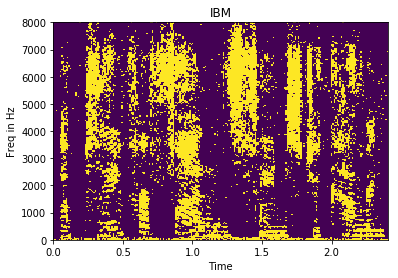

In [78]:
def IBM(noisy_speech,clean_speech):
    noise=noisy_speech-clean_speech
    mask=clean_speech
    mask[clean_speech>=noise]=1
    mask[clean_speech<noise]=0
    return mask
def IRM(noisy_speech,clean_speech):
    noise=noisy_speech-clean_speech
    speech_energy=np.array(clean_speech)**2
    noise=np.array(noise)**2
    irm = np.sqrt(speech_energy / (noise + speech_energy))
    return irm

ibm=IBM(noisy_signal,clean)
extent=[0,len(sx)/sr,0,8000]
plt.title("IBM")
plt.ylabel("Freq in Hz")
plt.xlabel("Time")
plt.imshow(ibm,origin='lowest',aspect='auto',extent=extent)

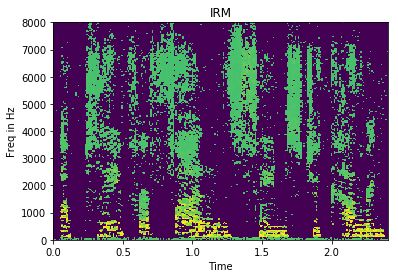

In [79]:
irm=IRM(noisy_signal,clean)
extent=[0,len(sx)/sr,0,8000]
plt.title("IRM")
plt.ylabel("Freq in Hz")
plt.xlabel("Time")
plt.imshow(irm,origin='lowest',aspect='auto',extent=extent)